# MATH50003 Numerical Analysis (2022–23)
# Lab 6: Least squares, QR and Cholesky
This lab explores the the least squares problem for fitting functions with polynomials,
computing the QR factorisation with both reflections and rotations,
and implementing a tridiagonal Cholesky decomposition (which we shall see later arises in the 1D Poisson equation).

In [1]:
using Plots, Test, LinearAlgebra

------

When $m = n$ a least squares fit by a polynomial becomes _interpolation_:
the approximating polynomial will fit the data exactly.
Whether an interpolation is actually close to a function is a subtle question,
involving properties of the function, distribution of the sample points $x_1,…,x_n$,
and round-off error.
A classic example is:
$$
  f_M(x) = {1 \over M x^2 + 1}
$$
where the choice of $M$ can dictate whether interpolation at evenly spaced points converges.

**Problem 1.1** Find and plot the best least squares fit of $f_M$ by degree $n$
polynomials for $n = 0,…,10$ at 1000 evenly spaced points between $0$ and $1$.

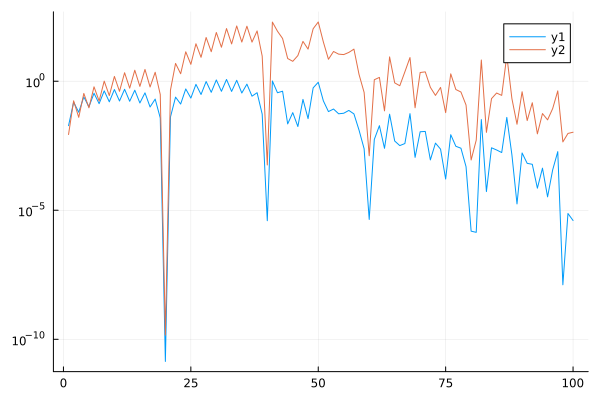

In [2]:
# SOLUTION

N = 100
err = zeros(N,2)
for n= 1:N
    x = range(-1, 1; length=n+1)
    f_10 = 1 ./ (10*x.^2 .+ 1)
    f_25 = 1 ./ (25*x.^2 .+ 1)
    V = x .^ (0:n)'
    c_10 = V \ f_10
    c_25 = V \ f_25
    err[n,1] = abs(1/(10*0.9^2+1) - dot(0.9 .^ (0:n), c_10))
    err[n,2] = abs(1/(25*0.9^2+1) - dot(0.9 .^ (0:n), c_25))
end

nanabs = x -> iszero(x) ? NaN : abs(x)
plot(nanabs.(err); yscale=:log10)


# END

-------

**Problem 2** Complete the following function that implements
 Householder QR using only $O(mn^2)$ operations.
You may choose to use your implementation of `Reflection` and `Reflections` from PS5.
Hint: to find the inner product of a vector `w` with each column of a matrix
`R` one can write `w'R`.

In [3]:
function householderqr(A)
    T = eltype(A)
    m,n = size(A)
    if m < n
        error("Only support more than or equal rows than columns")
    end
    # TODO: construct Q and R using O(m*n^2) operations
    # via Householder reflections.
    # SOLUTION
    # For simplicity in the code we won't use Reflection/Reflections.

    # R begins as A, modify it in place
    R = copy(A)
    Q = Matrix{T}(I, m, m) # makes an m × m matrix. Note using Reflection would lower this to `m × n` storage.
    for j = 1:n
        ## we need to find the right reflection vector
        y = copy(R[j:end, j])
        # choose the sign, careful about 0
        if y[1] ≥ 0
            s = 1
        else
            s = -1
        end
        y[1] += s * norm(y)
        w = y / norm(y)

        # we now apply the reflection to all columns of R
        R[j:end, :] = R[j:end, :] - 2 * w * (w' * R[j:end, :])
        # and update Q
        Q[j:end,:] = Q[j:end,:] - 2w * (w'*Q[j:end,:])
    end
    Q',R # transpose to reverse order reflections are applied
    # END
end

A = randn(6,4)
Q,R = householderqr(A)
@test Q*R ≈ A
@test Q'Q ≈ I

Test Passed

------

An alternative to using reflections to introduce zeros is to use rotations.
This is particularly convenient for tridiagonal matrices, where one needs to only
make one sub-diagonal zero. Here we explore a tridiagonal QR built from rotations
in a way that the factorisation can be computed in $O(n)$ operations.

**Problem 3.1** Complete the implementation of `Rotations`, which represents an orthogonal matrix `Q` that is a product
of rotations of angle `θ[k]`, each acting on the entries `k:k+1`. That is, it returns $Q = Q_1⋯Q_k$ such that
$$
Q_k[k:k+1,k:k+1] =
\begin{bmatrix}
\cos θ[k] & -\sin θ[k]\\
\sin θ[k] & \cos θ[k]
\end{bmatrix}
$$

In [4]:
struct Rotations{T} <: AbstractMatrix{T}
    θ::Vector{T} # a vector of angles
end

import Base: *, size, getindex

# we use the number of rotations to deduce the dimensions of the matrix
size(Q::Rotations) = (length(Q.θ)+1, length(Q.θ)+1)

function *(Q::Rotations, x::AbstractVector)
    T = promote_type(eltype(Q), eltype(x))
    y = Vector{T}(x) # copies x to a new Vector whose eltype is T
    # TODO: Apply Q in O(n) operations, modifying y in-place

    # SOLUTION
    θ = Q.θ
    # Does Q1....Qn x
    for k = length(θ):-1:1
        #below has 4 ops to make the matrix and 12 to do the matrix-vector multiplication,
        #total operations will be 48n = O(n)
        c, s = cos(θ[k]), sin(θ[k])
        y[k:(k+1)] = [c -s; s c] * y[k:(k+1)]
    end
    # END

    y
end

function getindex(Q::Rotations, k::Int, j::Int)
    # TODO: Return Q[k,j] in O(n) operations (hint: use *)

    # SOLUTION
    # recall that A_kj = e_k'*A*e_j for any matrix A
    # so if we use * above, this will take O(n) operations
    n = size(Q)[1]
    ej = zeros(eltype(Q), n)
    ej[j] = 1
    # note, must be careful to ensure that ej is a VECTOR
    # not a MATRIX, otherwise * above will not be used
    Qj = Q * ej
    Qj[k]
    # END
end

θ1 = randn(5)
Q = Rotations(θ1)
@test Q'Q ≈ I
@test Rotations([π/2, -π/2]) ≈ [0 0 -1; 1 0 0; 0 -1 0]

# When one computes a tridiagonal QR, we introduce entries in the

Test Passed

second super-diagonal. Thus we will use the `UpperTridiagonal` type
from Lab 4:

In [5]:
import Base: *, size, getindex, setindex!
struct UpperTridiagonal{T} <: AbstractMatrix{T}
    d::Vector{T}   # diagonal entries
    du::Vector{T}  # super-diagonal enries
    du2::Vector{T} # second-super-diagonal entries
end

size(U::UpperTridiagonal) = (length(U.d),length(U.d))

function getindex(U::UpperTridiagonal, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    # TODO: return U[k,j]
    # SOLUTION
    if j - k == 0
        d[j]
    elseif j - k == 1
        du[k]
    elseif j - k == 2
        du2[k]
    else
        0
    end
    # END
end

function setindex!(U::UpperTridiagonal, v, k::Int, j::Int)
    d,du,du2 = U.d,U.du,U.du2
    if j > k+2
        error("Cannot modify off-band")
    end

    # TODO: modify d,du,du2 so that U[k,j] == v
    # SOLUTION
    if j - k == 0
        d[k] = v
    elseif j - k == 1
        du[k] = v
    elseif j - k == 2
        du2[k] = v
    else
        error("Cannot modify off-band")
    end
    # END

    U # by convention we return the matrix
end

setindex! (generic function with 124 methods)

**Problem 3.2** Combine `Rotations` and `UpperTridiagonal` from last problem sheet
to implement a banded QR decomposition, `bandedqr`, that only takes $O(n)$ operations. Hint: the
`atan(y,x)` function gives the angle of a vector [x,y].

In [6]:
function bandedqr(A::Tridiagonal)
    n = size(A, 1)
    Q = Rotations(zeros(n - 1)) # Assume Float64
    R = UpperTridiagonal(zeros(n), zeros(n - 1), zeros(n - 2))

    # TODO: Populate Q and R by looping through the columns of A.

    # SOLUTION
    R[1, 1:2] = A[1, 1:2]

    for j = 1:n-1
        # angle of rotation
        Q.θ[j] = atan(A[j+1, j], R[j, j])
        θ = -Q.θ[j] # rotate in opposite direction

        c, s = cos(θ), sin(θ)
        # [c -s; s c] represents the rotation that introduces a zero.
        # This is [c -s; s c] to j-th column, but ignore second row
        # which is zero
        R[j, j] = c * R[j, j] - s * A[j+1, j]
        # This is [c -s; s c] to (j+1)-th column
        R[j:j+1, j+1] = [c -s; s c] * [R[j, j+1]; A[j+1, j+1]]

        if j < n - 1
            # This is [c -s; s c] to (j+2)-th column, where R is still zero
            R[j:j+1, j+2] = [-s; c] * A[j+1, j+2]
        end
    end
    # END
    Q, R
end

A = Tridiagonal([1, 2, 3, 4], [1, 2, 3, 4, 5], [1, 2, 3, 4])
Q, R = bandedqr(A)
@test Q*R ≈ A

Test Passed

--------

We now consider a Cholesky factorisation for tridiagonal matrices. Since we are assuming the
matrix is symmetric, we will use a special type `SymTridiagonal` that captures the symmetry.
In particular, `SymTridiagonal(dv, eu) == Tridiagonal(ev, dv, ev)`.

**Problem 4** Complete the following
implementation of `cholesky` to return a `Bidiagonal` cholesky factor in $O(n)$ operations.

In [7]:
import LinearAlgebra: cholesky

return a Bidiagonal L such that L'L == A (up to machine precision)
You are allowed to change A

In [8]:
function cholesky(A::SymTridiagonal)
    d = A.dv # diagonal entries of A
    u = A.ev # sub/super-diagonal entries of A
    T = float(eltype(A)) # return type, make float in case A has Ints
    n = length(d)
    ld = zeros(T, n) # diagonal entries of L
    ll = zeros(T, n-1) # sub-diagonal entries of L

    # SOLUTION
    ld[1] = sqrt(d[1])
    for k = 1:n-1
        ll[k] = u[k]/ld[k]
        ld[k+1] = sqrt(d[k+1]-ll[k]^2)
    end
    # END

    Bidiagonal(ld, ll, :L)
end

n = 1000
A = SymTridiagonal(2*ones(n),-ones(n-1))
L = cholesky(A)
@test L ≈ cholesky(Matrix(A)).L

Test Passed

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*